# Loading the data

The data will be stored in two dataframes:
- `df_stocks`: all the stocks
- `df_bench`: only the benchmarks

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import dateutil
import glob
import os

In [2]:
# listing pandas dataframes previously saved
lst_df_path = glob.glob(os.path.join('preprocessed', 'df_*.pickle'))

In [3]:
# checking the path and file names
lst_df_path[:3]

['preprocessed/df_PETR3.pickle',
 'preprocessed/df_JBSS3.pickle',
 'preprocessed/df_CIEL3.pickle']

In [4]:
# remove the ticker that will be used for Benchmarks later
lst_df_path.remove('preprocessed/df_BVSP.pickle')
lst_df_path.remove('preprocessed/df_USDBRL.pickle')

In [5]:
# creating a separed list for the Benchmarks
lst_df_path_bench = ['preprocessed/df_BVSP.pickle', 'preprocessed/df_USDBRL.pickle']

In [6]:
# concatenating all stocks into one dataframe
lst_df_stocks = []

for fname in lst_df_path:
    df = pd.read_pickle(fname)
    # keeping only Adj Close
    df.drop(columns=['Open', 'High', 'Low', 'Close', 'Volume', 'Adj Open',
            'Adj High', 'Adj Low'], inplace=True)
    ticker = fname.split('/')[1].split('df_')[1].split('.')[0] 
    df.columns = [ticker]
    lst_df_stocks.append(df)
    
df_stocks = pd.concat(lst_df_stocks, axis=1)

In [7]:
df_stocks = pd.concat(lst_df_stocks, axis=1)

In [8]:
# checking column names
df_stocks.columns

Index(['PETR3', 'JBSS3', 'CIEL3', 'FLRY3', 'ABEV3', 'IGTA3', 'CPFE3', 'VIVT4',
       'CSNA3', 'EMBR3', 'VALE3', 'EQTL3', 'B3SA3', 'UGPA3', 'CYRE3', 'ESTC3',
       'GOAU4', 'PETR4', 'LREN3', 'PCAR4', 'MRVE3', 'TIMP3', 'ELET6', 'EGIE3',
       'LAME4', 'KROT3', 'CMIG4', 'BBDC4', 'BRAP4', 'RENT3', 'ITUB4', 'QUAL3',
       'USIM5', 'GGBR4', 'BBSE3', 'ITSA4', 'MRFG3', 'BRFS3', 'MGLU3', 'BRML3',
       'RADL3', 'HYPE3', 'MULT3', 'BRKM5', 'BBDC3', 'NATU3', 'ENBR3', 'CCRO3',
       'ELET3', 'CPLE6', 'SBSP3', 'FIBR3', 'ECOR3', 'CSAN3', 'WEGE3', 'BBAS3'],
      dtype='object')

In [9]:
# concatenating the benchmarks into one dataframe
lst_df_bench = []

for fname in lst_df_path_bench:
    df = pd.read_pickle(fname)
    # keeping only Adj Close
    df.drop(columns=['Open', 'High', 'Low', 'Close', 'Volume', 'Adj Open',
            'Adj High', 'Adj Low'], inplace=True)
    ticker = fname.split('/')[1].split('df_')[1].split('.')[0] 
    df.columns = [ticker]
    lst_df_bench.append(df)
    
df_bench = pd.concat(lst_df_bench, axis=1)

In [10]:
df_bench.columns

Index(['BVSP', 'USDBRL'], dtype='object')

In [11]:
df_bench.head()

,BVSP,USDBRL
Date,,
2016-01-01,42141.0,3.9500
2016-01-04,42141.0,3.9491
2016-01-05,42419.0,4.0373
2016-01-06,41773.0,4.0269
2016-01-07,40695.0,4.0199


# Monthly Optimized Portfolio

The objective is to compose a portfolio with good performance using only a small number of stocks from the list.

For each month a new portfolio will be elaborated based on the Sharpe Ratio from the previous months, and its performance will be compared with three benchmarks:
- iBovespa: the official Index of Bovespa (composed of +60 stocks)
- Avg. BVSP: the simple average of all available stocks of iBovespa
- Dolar: The current value of USD Dolars in Brazilian *Reais*

Additional constraints to the Portfolio:
- The max weight of a share is 25%
- The minimum weight of a share is 2%

**Expected results:**
- improved performance on the long run
- higher volatility than iBovespa, due to small number of stocks composing the portfolio



## Setting the optimization

Based on Jose Portilla's Udemy course [Python for finance and trading algorithm](https://www.udemy.com/python-for-finance-and-trading-algorithms/learn/v4/).

In [12]:
from scipy.optimize import minimize

In [13]:
# utility function to obtain the expected Return, expected Volatity, and Sharpe Ration from the log returns, given the weights
def get_ret_vol_sr(weights):
    global log_ret
    weights = np.array(weights)    
    ret = np.sum( log_ret.mean() * weights * 252)
    vol = np.sqrt( np.dot(weights.T, np.dot(log_ret.cov()*252, weights)))
    sr = ret/vol
    return np.array([ret, vol, sr])

In [14]:
# the actual function to be minimized
def neg_sharpe(weights):
    return -1.*get_ret_vol_sr(weights)[2]

In [15]:
# contraint function
def check_sum(weights):
    return np.sum(weights) - 1.

In [16]:
# contraint function
def check_max_weight(weights):
    global max_weight
    return np.minimum(weights.max(), max_weight) - weights.max()

In [17]:
# contraint function
def check_weights(weights):
    global max_weight
    w1 = np.sum(weights) - 1.
    w2 = np.minimum(weights.max(), max_weight) - weights.max()
    return np.abs(w1) + np.abs(w2)

In [18]:
# constraint tuple
#cons = ({'type' : 'eq', 'fun' : check_sum})
#cons = ({'type' : 'eq', 'fun' : check_sum}, {'type' : 'eq', 'fun' : check_max_weight}) # did not work
cons = ({'type' : 'eq', 'fun' : check_weights}) # using this workaround instead

In [19]:
n_stocks = df_stocks.shape[1]

In [20]:
bounds = tuple([(0,1) for i in range(n_stocks)])

In [21]:
init_guess = np.ones(n_stocks) / n_stocks

## Setting prediction parameters

In [22]:
# the start date of the fist prediction (year, month, day)
day_start = datetime.datetime(2017,1,1).date()

# total number of months to run the prediction
n_months_run = 15

# training months before current prediction
n_months_train = 10

# portfolio weights (before re-balancing)
max_weight = 0.25  # used in the constraint function
min_weight = 0.02  # used in the running prediction


## Running monthly prediction

In [23]:

delta_month = dateutil.relativedelta.relativedelta(months=+1)
delta_day = dateutil.relativedelta.relativedelta(days=+1)

valid_start = day_start
valid_end = valid_start + delta_month - delta_day

train_start = valid_start - n_months_train*delta_month
train_end = valid_start - delta_day

time = []
p = []
b1 = []
b2 = []
b3 = []


#
for i in range(n_months_run):
    
    # dataframes
    df_train = df_stocks.truncate(before=train_start, after=train_end)
    df_valid = df_stocks.truncate(before=valid_start, after=valid_end)
    df_valid_bench = df_bench.truncate(before=valid_start, after=valid_end)
    
    # calculating log returns of the training data
    log_ret = np.log( df_train.divide(df_train.shift(1, axis=0), axis=0) ).iloc[2:]
    # notice that log_ret is used by the function `get_ret_vol_sr` and, consequently,
    # the `neg_sharpe` function    
      
    
    # calculating optimized weights
    opt_results = minimize(neg_sharpe, init_guess, method='SLSQP', bounds=bounds, constraints=cons)
    
    weights = opt_results.x
    
    
    # Weight Re-balancing
    idx = np.where(opt_results.x>=min_weight)[0]
    weights = weights[idx]
    weights /= weights.sum()
    
    labels = log_ret.columns[idx]
    
    # using the portfolio weights on the validation data
    df1 = df_valid[labels]
    df1 = df1/df1.iloc[0] # percentage return of the portfolio
    df2 = (df1 * weights).sum(axis=1)
    df2 = df2/df2.iloc[0] # percentage return of the portfolio
    
    # percentage return of the benchmarks
    df2b = df_valid_bench/df_valid_bench.iloc[0]
    
    time.append(valid_start.strftime('%Y/%m'))
    p.append(df2.iloc[-1])
    b1.append(df2b['BVSP'].iloc[-1])
    b2.append(df2b['USDBRL'].iloc[-1])
    b3.append(df1.mean(axis=1).iloc[-1]) # Simple average of all stocks
    
    print('\nStart: {}, Portfolio: {:.2f}, iBovespa: {:.2f}, Dolar: {:.2f}, Avg. : {:.2f}'.format(time[-1], p[-1],
                                                                                                 b1[-1], b2[-1], b3[-1]))
    
    for l,w in zip(labels, weights):
        print('  > {} : {:.2f}'.format(l, w))

    
    # time update for the next loop
    valid_start += delta_month
    valid_end  = valid_start + delta_month - delta_day
    
    train_start += delta_month
    train_end = valid_start - delta_day    
    


Start: 2017/01, Portfolio: 1.08, iBovespa: 1.09, Dolar: 0.96, Avg. : 1.08
  > FLRY3 : 0.25
  > CPFE3 : 0.20
  > EQTL3 : 0.04
  > ELET6 : 0.10
  > BRAP4 : 0.08
  > QUAL3 : 0.03
  > MGLU3 : 0.12
  > ELET3 : 0.10
  > FIBR3 : 0.07

Start: 2017/02, Portfolio: 1.12, iBovespa: 1.03, Dolar: 0.99, Avg. : 1.11
  > FLRY3 : 0.25
  > CPFE3 : 0.18
  > EQTL3 : 0.08
  > ELET6 : 0.10
  > BRAP4 : 0.12
  > MGLU3 : 0.12
  > ELET3 : 0.08
  > FIBR3 : 0.06

Start: 2017/03, Portfolio: 0.93, iBovespa: 0.97, Dolar: 1.01, Avg. : 0.92
  > FLRY3 : 0.25
  > CPFE3 : 0.25
  > EQTL3 : 0.07
  > BRAP4 : 0.09
  > MGLU3 : 0.18
  > ELET3 : 0.16

Start: 2017/04, Portfolio: 1.11, iBovespa: 1.01, Dolar: 1.02, Avg. : 1.08
  > FLRY3 : 0.25
  > CPFE3 : 0.22
  > MRVE3 : 0.04
  > TIMP3 : 0.08
  > BRAP4 : 0.12
  > MGLU3 : 0.15
  > ELET3 : 0.10
  > BBAS3 : 0.05

Start: 2017/05, Portfolio: 1.05, iBovespa: 0.96, Dolar: 1.02, Avg. : 1.04
  > FLRY3 : 0.22
  > CPFE3 : 0.26
  > MRVE3 : 0.10
  > TIMP3 : 0.13
  > MGLU3 : 0.12
  > BRKM5 : 0

## Presenting the results

In [24]:
d = {'Date' : pd.to_datetime(time),
    'Portfolio' : p,
    'iBovespa' : b1,
    'Dolar' : b2,
    'Avg. BVSP' : b3}
df_results = pd.DataFrame(data=d)
df_results.set_index('Date', inplace=True)

In [25]:
print('Average - Monthly returns:')
df_results.mean(axis=0)

Average - Monthly returns:


Avg. BVSP    1.037938
Dolar        1.003667
Portfolio    1.043454
iBovespa     1.023198
dtype: float64

In [26]:
print('std - Monthly returns:')
df_results.std(axis=0)

std - Monthly returns:


Avg. BVSP    0.067024
Dolar        0.022295
Portfolio    0.071640
iBovespa     0.043629
dtype: float64

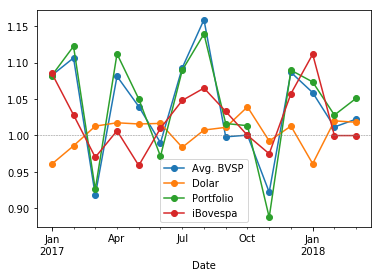

In [27]:
ax = df_results.plot(style='-o')
ax.axhline(y=1.0, color='gray', linestyle='--', lw=0.5)